# Bayesian Gaussian Mixture Modeling using TensorFlow Probability

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
# tf.compat.v1.enable_eager_execution()  # Eager execution significantly slows down MCMC

import sys
import time
import functools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from operator import mul
from sklearn.cluster import KMeans

%matplotlib inline

print('TensorFlow version:', tf.__version__)
print('TensorFlow Probability version:', tfp.__version__)


  TensorFlow's `tf-nightly` package will soon be updated to TensorFlow 2.0.

  Please upgrade your code to TensorFlow 2.0:
    * https://www.tensorflow.org/beta/guide/migration_guide

  Or install the latest stable TensorFlow 1.X release:
    * `pip install -U "tensorflow==1.*"`

  Otherwise your code may be broken by the change.

  
TensorFlow version: 1.15.0-dev20190821
TensorFlow Probability version: 0.9.0-dev20191002


In [2]:
def session_options(enable_gpu_ram_resizing=True):
    """Convenience function which sets common `tf.Session` options."""
    config = tf.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    return config

def reset_sess(config=None):
    """Convenience function to create the TF graph and session, or reset them."""
    if config is None:
        config = session_options()
    tf.reset_default_graph()
    global sess
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)

reset_sess()

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Quadro P1000, pci bus id: 0000:01:00.0, compute capability: 6.1



## Generate some data

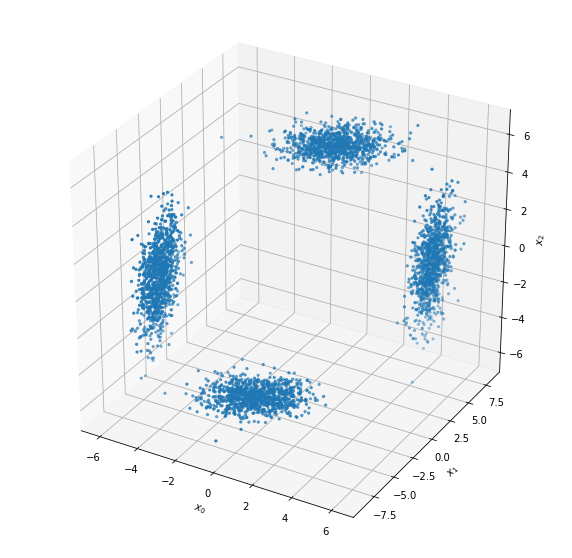

In [3]:
eps = 1e-6

n_samples_per_component = 1000
n_dims = 3
X = []
X.append(np.random.multivariate_normal([5, 5, 0],
                                       [[0.1, 0, 0], [0, 1, 0.6], [0, 0.6, 2]],
                                       n_samples_per_component).astype('float64'))
X.append(np.random.multivariate_normal([-5, -5, 0],
                                       [[0.1, 0, 0], [0, 1, 0.6], [0, 0.6, 2]],
                                       n_samples_per_component).astype('float64'))
X.append(np.random.multivariate_normal([0, 5, 5],
                                       [[1, 0.6, 0], [0.6, 1, 0], [0, 0, 0.2]],
                                       n_samples_per_component).astype('float64'))
X.append(np.random.multivariate_normal([0, -5, -5],
                                       [[1, 0.6, 0], [0.6, 1, 0], [0, 0, 0.2]],
                                       n_samples_per_component).astype('float64'))
n_components = len(X)
n_samples = n_samples_per_component * n_components
X = np.concatenate(X)

# Plot the data
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker='.')
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')
ax.set_zlabel('$x_2$')
plt.show()

## Build a Gaussian Mixture Model
$$
\begin{aligned}
\mathbf{x}_n &\sim \sum\limits_k \pi_k \mathcal{N}\left(\pmb{\mu_x}_k, \pmb{\Sigma_x}_k\right)\\
\pi_k &\sim \mathcal{D}\left(K, \mathbf{c}\right)\\
\forall k \quad&\left\{
    \begin{aligned}
    \pmb{\Sigma_x}_k^{-1} &\sim \mathcal{W}\left(\mathbf{W}, \nu\right)\\
    \pmb{\mu_x}_k &\sim \mathcal{N}\left(\pmb{\mu_0}, \pmb{\Sigma_0}\right)
    \end{aligned}
\right.
\end{aligned}
$$

### prior distributions

In [4]:
theta_prior = tfd.Dirichlet(
    concentration=2 * np.ones(n_components, dtype=np.float64), name='theta_prior',
    validate_args=True, allow_nan_stats=False)

mu_prior = tfd.Independent(
    tfd.Normal(loc=np.stack([np.zeros(n_dims, dtype=np.float64)] * n_components),
               scale=tf.ones((n_components, n_dims), dtype=np.float64),
               validate_args=True, allow_nan_stats=False),
    reinterpreted_batch_ndims=1,
    name='mu_prior',
    validate_args=True)

invcov_chol_prior = tfd.Wishart(df=n_dims+2,
                           scale_tril=np.stack([np.eye(n_dims, dtype=np.float64)] * n_components),
                           input_output_cholesky=True,
                           name='invcov_chol_prior',
                           validate_args=True, allow_nan_stats=False)

### joint log probability

In [5]:
def joint_log_prob(x, theta, mu, invcov_chol):
    """BGMM with priors: theta=Dirichlet, mu=Normal, invcov_chol=Wishart

    Args:
    x: `[n, d]`-shaped `Tensor` representing Bayesian Gaussian Mixture model draws.
       Each sample is a length-`d` vector.
    theta: `[K]`-shaped `Tensor` representing random draw from `SoftmaxInverse(Dirichlet)` prior.
    mu: `[K, d]`-shaped `Tensor` representing the location parameter of the `K` components.
    invcov_chol: `[K, d, d]`-shaped `Tensor` representing `K` lower triangular `cholesky(Precision)` matrices,
                 each being sampled from a Wishart distribution.

    Returns:
    log_prob: `Tensor` representing joint log-density over all inputs.
    """
    cov = tf.linalg.inv(tf.matmul(invcov_chol, tf.linalg.matrix_transpose(invcov_chol)))

    gmm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=theta),
        components_distribution=tfd.MultivariateNormalTriL(loc=mu,
                                                           scale_tril=tf.linalg.cholesky(cov)))
    log_prob_parts = [
        gmm.log_prob(x),  # log probabilities (summed to be log-likelihoods)
        theta_prior.log_prob(theta)[..., tf.newaxis],  # prior probabilities of theta
        mu_prior.log_prob(mu),  # prior probabilities of mu
        invcov_chol_prior.log_prob(invcov_chol)  # prior probabilities of invcov_chol
    ]
    sum_log_prob = tf.reduce_sum(tf.concat(log_prob_parts, axis=-1), axis=-1)  # joint log probabilities
    return sum_log_prob

## Bayesian Inference using Markov chain Monte Carlo (MCMC) algorithms

In [6]:
unnormalized_posterior_log_prob = functools.partial(joint_log_prob, X)

### set up initial states

In [7]:
initial_state = [
    (1 / n_components) * tf.ones(n_components, dtype=tf.float64, name='theta'),
    tf.convert_to_tensor(np.array([[5, 5, 0],
                                   [-5, -5, 0],
                                   [0, 5, 5],
                                   [0, -5, -5]], dtype=np.float64),
                         name='mu'),
    tf.matrix_diag(tf.ones((n_components, n_dims), dtype=tf.float64), name='invcov_chol')
]

### unconstrained representation
MCMC requires the target log-probability function be differentiable with respect to its arguments. Furthermore, MCMC can exhibit dramatically higher statistical efficiency if the state-space is unconstrained.

To address this requirement we'll need to:

1. transform the constrained variables to an unconstrained space;
2. run the MCMC in unconstrained space;
3. transform the unconstrained variables back to the constrained space.

In [8]:
# bijectors transforms the unconstrained variables back to the constrained space
unconstraining_bijectors = [
    tfb.SoftmaxCentered(validate_args=True),  # transform unconstrained theta values to discrete probability vectors
    tfb.Identity(validate_args=True),  # identity transformation (no transformation) for mu values
    tfb.Chain([
        tfb.TransformDiagonal(tfb.Softplus(), validate_args=True),
        tfb.FillTriangular(validate_args=True)
    ])  # transforms unconstrained invcov_chol values to lower triangular matrices with positive diagonal
]

### graph for Random Walk Metropolis (RWM) sampling (Method 1)

In [9]:
n_results = 16000
n_burnin_steps = 8000
scale = 1e-3
[theta, mu, invcov_chol], kernel_results = tfp.mcmc.sample_chain(num_results=n_results,
                                                                 num_burnin_steps=n_burnin_steps,
                                                                 current_state=initial_state,
                                                                 kernel=tfp.mcmc.TransformedTransitionKernel(
                                                                     inner_kernel=tfp.mcmc.RandomWalkMetropolis(
                                                                         target_log_prob_fn=unnormalized_posterior_log_prob,
                                                                         new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=scale)),
                                                                     bijector=unconstraining_bijectors),
                                                                 parallel_iterations=100)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


C:\ProgramData\Anaconda3\envs\nightly\lib\site-packages\tensorflow_probability\python\mcmc\sample.py:336: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


### launch the graph and display the inferred statistics

In [10]:
acceptance_rate = tf.reduce_mean(tf.to_float(kernel_results.inner_results.is_accepted))

theta = theta[n_burnin_steps:]
mu = mu[n_burnin_steps:]
invcov_chol = invcov_chol[n_burnin_steps:]
cov = tf.linalg.inv(tf.matmul(invcov_chol, tf.linalg.matrix_transpose(invcov_chol)))

mean_theta = tf.reduce_mean(theta, axis=0)
mean_mu = tf.reduce_mean(mu, axis=0)
mean_invcov_chol = tf.reduce_mean(invcov_chol, axis=0)
mean_cov = tf.reduce_mean(cov, axis=0)

start_time = time.time()
[val_acceptance_rate, val_mean_theta, val_mean_mu, val_mean_invcov_chol, val_mean_cov] = sess.run(
    [acceptance_rate, mean_theta, mean_mu, mean_invcov_chol, mean_cov])
elapsed_time = time.time() - start_time
print('elapsed time: {:.2f}s'.format(elapsed_time))

print('acceptance_rate:', val_acceptance_rate)
print('avg mix probs:', val_mean_theta)
print('\navg loc:\n', val_mean_mu)
print('\navg precision cholesky:\n', val_mean_invcov_chol)
print('\navg covariance matrix:\n', val_mean_cov)

Instructions for updating:
Use `tf.cast` instead.
elapsed time: 125.47s
acceptance_rate: 0.8605625
avg mix probs: [0.24210422 0.2462745  0.25332653 0.25829475]

avg loc:
 [[ 5.00693194  5.02211309 -0.02235332]
 [-4.98893324 -5.00272279  0.05210668]
 [-0.01956473  4.98041218  5.00443621]
 [ 0.02551949 -4.92956261 -4.98401458]]

avg precision cholesky:
 [[[ 2.55711769  0.          0.        ]
  [-0.00365746  1.08171761  0.        ]
  [ 0.01109931 -0.32181222  0.67361808]]

 [[ 2.61837409  0.          0.        ]
  [ 0.01776231  1.09021282  0.        ]
  [-0.01872399 -0.29748029  0.65813314]]

 [[ 1.15226969  0.          0.        ]
  [-0.73339288  0.99126436  0.        ]
  [-0.02464989 -0.08933858  1.96432655]]

 [[ 1.23240055  0.          0.        ]
  [-0.74732921  1.03117297  0.        ]
  [-0.06941121 -0.04458186  2.10048292]]]

avg covariance matrix:
 [[[ 1.53744922e-01 -1.69744534e-03 -9.04070728e-03]
  [-1.69744534e-03  1.05058209e+00  6.56353684e-01]
  [-9.04070728e-03  6.5635368

### graph for Hamiltonian Monte Carlo (HMC) sampling (Method 2)

In [11]:
n_results = 4000
n_burnin_steps = 2000
step_size = 1e-2
num_leapfrog_steps = 10
[theta, mu, invcov_chol], kernel_results = tfp.mcmc.sample_chain(num_results=n_results,
                                                                 num_burnin_steps=n_burnin_steps,
                                                                 current_state=initial_state,
                                                                 kernel=tfp.mcmc.TransformedTransitionKernel(
                                                                     inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
                                                                         target_log_prob_fn=unnormalized_posterior_log_prob,
                                                                         step_size=step_size,
                                                                         num_leapfrog_steps=num_leapfrog_steps),
                                                                     bijector=unconstraining_bijectors),
                                                                 parallel_iterations=100)

C:\ProgramData\Anaconda3\envs\nightly\lib\site-packages\tensorflow_probability\python\mcmc\sample.py:336: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


### launch the graph and display the inferred statistics

In [12]:
acceptance_rate = tf.reduce_mean(tf.to_float(kernel_results.inner_results.is_accepted))

theta = theta[n_burnin_steps:]
mu = mu[n_burnin_steps:]
invcov_chol = invcov_chol[n_burnin_steps:]
cov = tf.linalg.inv(tf.matmul(invcov_chol, tf.linalg.matrix_transpose(invcov_chol)))

mean_theta = tf.reduce_mean(theta, axis=0)
mean_mu = tf.reduce_mean(mu, axis=0)
mean_invcov_chol = tf.reduce_mean(invcov_chol, axis=0)
mean_cov = tf.reduce_mean(cov, axis=0)

start_time = time.time()
[val_acceptance_rate, val_mean_theta, val_mean_mu, val_mean_invcov_chol, val_mean_cov] = sess.run(
    [acceptance_rate, mean_theta, mean_mu, mean_invcov_chol, mean_cov])
elapsed_time = time.time() - start_time
print('elapsed time: {:.2f}s'.format(elapsed_time))

print('acceptance_rate:', val_acceptance_rate)
print('avg mix probs:', val_mean_theta)
print('\navg loc:\n', val_mean_mu)
print('\navg precision cholesky:\n', val_mean_invcov_chol)
print('\navg covariance matrix:\n', val_mean_cov)

elapsed time: 780.11s
acceptance_rate: 0.85775
avg mix probs: [0.25001723 0.25013043 0.24993011 0.24992223]

avg loc:
 [[ 5.00932808e+00  5.03454005e+00  4.54800531e-02]
 [-4.98943210e+00 -5.00100203e+00  3.84989160e-02]
 [-2.38035072e-02  4.95804823e+00  5.00835974e+00]
 [ 3.99547850e-03 -4.97411596e+00 -4.98128422e+00]]

avg precision cholesky:
 [[[ 3.09098876e+00  0.00000000e+00  0.00000000e+00]
  [-8.82663966e-03  1.12135576e+00  0.00000000e+00]
  [ 1.61393524e-03 -3.27819233e-01  6.96798350e-01]]

 [[ 3.28776020e+00  0.00000000e+00  0.00000000e+00]
  [ 1.04769297e-02  1.11405120e+00  0.00000000e+00]
  [-1.96056949e-02 -3.04669129e-01  6.88785743e-01]]

 [[ 1.20868541e+00  0.00000000e+00  0.00000000e+00]
  [-7.40928816e-01  9.83870672e-01  0.00000000e+00]
  [-1.18921317e-01 -4.36199033e-02  2.12120343e+00]]

 [[ 1.24018367e+00  0.00000000e+00  0.00000000e+00]
  [-7.46015406e-01  1.02069605e+00  0.00000000e+00]
  [-7.70464895e-02 -5.12052308e-04  2.22434605e+00]]]

avg covariance ma

### graph for Metropolis-adjusted Langevin algorithm (MALA) sampling (Method 3)

In [13]:
n_results = 4000
n_burnin_steps = 2000
step_size = 2e-4
[theta, mu, invcov_chol], kernel_results = tfp.mcmc.sample_chain(num_results=n_results,
                                                                 num_burnin_steps=n_burnin_steps,
                                                                 current_state=initial_state,
                                                                 kernel=tfp.mcmc.TransformedTransitionKernel(
                                                                     inner_kernel=tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(
                                                                         target_log_prob_fn=unnormalized_posterior_log_prob,
                                                                         step_size=step_size),
                                                                     bijector=unconstraining_bijectors),
                                                                 parallel_iterations=100)

C:\ProgramData\Anaconda3\envs\nightly\lib\site-packages\tensorflow_probability\python\mcmc\sample.py:336: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


### launch the graph and display the inferred statistics

In [14]:
acceptance_rate = tf.reduce_mean(tf.to_float(kernel_results.inner_results.is_accepted))

theta = theta[n_burnin_steps:]
mu = mu[n_burnin_steps:]
invcov_chol = invcov_chol[n_burnin_steps:]
cov = tf.linalg.inv(tf.matmul(invcov_chol, tf.linalg.matrix_transpose(invcov_chol)))

mean_theta = tf.reduce_mean(theta, axis=0)
mean_mu = tf.reduce_mean(mu, axis=0)
mean_invcov_chol = tf.reduce_mean(invcov_chol, axis=0)
mean_cov = tf.reduce_mean(cov, axis=0)

start_time = time.time()
[val_acceptance_rate, val_mean_theta, val_mean_mu, val_mean_invcov_chol, val_mean_cov] = sess.run(
    [acceptance_rate, mean_theta, mean_mu, mean_invcov_chol, mean_cov])
elapsed_time = time.time() - start_time
print('elapsed time: {:.2f}s'.format(elapsed_time))

print('acceptance_rate:', val_acceptance_rate)
print('avg mix probs:', val_mean_theta)
print('\navg loc:\n', val_mean_mu)
print('\navg precision cholesky:\n', val_mean_invcov_chol)
print('\navg covariance matrix:\n', val_mean_cov)

elapsed time: 126.65s
acceptance_rate: 0.61625
avg mix probs: [0.25004926 0.25138162 0.25192013 0.24664898]

avg loc:
 [[ 5.009615    5.03971661  0.04228772]
 [-4.98918349 -5.00618135  0.03686342]
 [-0.02498103  4.95644861  5.00965311]
 [ 0.0118697  -4.96817279 -4.98110425]]

avg precision cholesky:
 [[[ 3.10273566e+00  0.00000000e+00  0.00000000e+00]
  [-8.32707338e-03  1.11495741e+00  0.00000000e+00]
  [ 1.47549773e-03 -3.24110895e-01  6.96896538e-01]]

 [[ 3.27864518e+00  0.00000000e+00  0.00000000e+00]
  [ 1.06561374e-03  1.11107142e+00  0.00000000e+00]
  [-1.61196945e-02 -3.04020437e-01  6.88384852e-01]]

 [[ 1.21244936e+00  0.00000000e+00  0.00000000e+00]
  [-7.46911389e-01  9.84105356e-01  0.00000000e+00]
  [-1.38745753e-01 -6.16150965e-02  2.12383663e+00]]

 [[ 1.23774723e+00  0.00000000e+00  0.00000000e+00]
  [-7.49986332e-01  1.02350219e+00  0.00000000e+00]
  [-5.38268771e-02 -6.56491697e-02  2.22241500e+00]]]

avg covariance matrix:
 [[[1.04179571e-01 2.42883608e-03 6.490407